In [3]:
import pandas as pd 

# Thư viện bắt buộc
from pandas_datareader.data import DataReader

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# vẽ biểu đồ 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# xử lý thời gian 
from datetime import datetime

# keras for LSTM 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [4]:
# Read the CSV file and set 'Date' as the index
df = pd.read_csv('Apple_Stock_Prices.csv')
df.set_index('Date', inplace=True)

# Convert the 'Date' index to datetime format
df.index = pd.to_datetime(df.index, dayfirst=True)

# Filter the DataFrame 
start_date = '2005/02/01'
end_date = '2023/01/27'
mask = (df.index >= start_date) & (df.index <= end_date)
df_filtered = df.loc[mask]
df_filtered

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-02-01,1.375893,1.388750,1.367500,1.384464,1.180142,678395200
2005-02-02,1.391964,1.426964,1.387321,1.421964,1.212108,1020062400
2005-02-03,1.412500,1.418393,1.380893,1.389464,1.184404,731651200
2005-02-04,1.390536,1.409464,1.384464,1.407857,1.200083,563556000
2005-02-07,1.409464,1.416964,1.383929,1.409643,1.201605,524456800
...,...,...,...,...,...,...
2023-01-23,138.119995,143.320007,137.899994,141.110001,141.110001,81760300
2023-01-24,140.309998,143.160004,140.300003,142.529999,142.529999,66435100
2023-01-25,140.889999,142.429993,138.809998,141.860001,141.860001,65799300


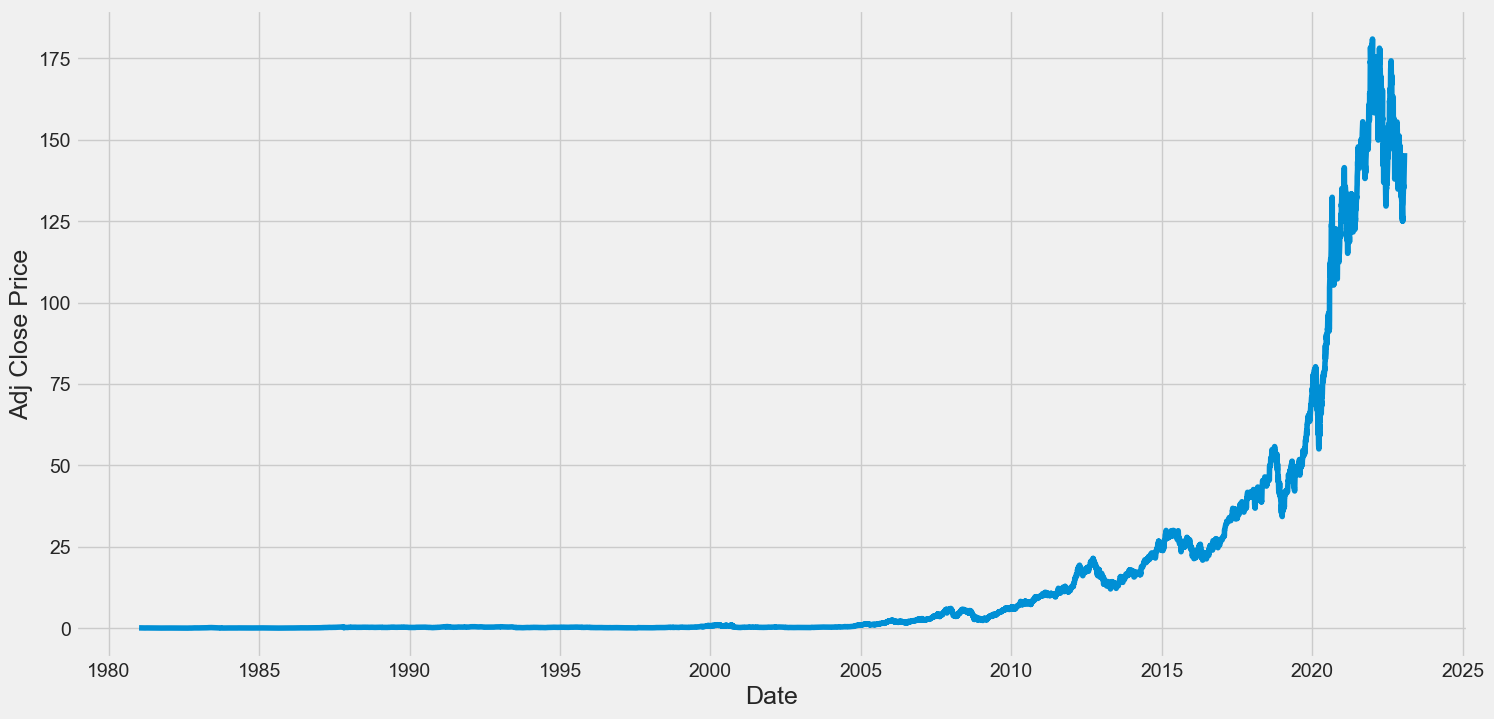

In [5]:
plt.figure(figsize=(16,8))
plt.plot(df['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close Price', fontsize=18)
plt.show()

In [6]:
def splitDataset(df):
    length = df.shape[0]
    train_df = df[:length - 30]
    test_df = df[length - 30:]
    return train_df, test_df

train_df, test_df = splitDataset(df)

train_df.shape, test_df.shape

((10578, 6), (30, 6))

In [7]:
# tạo dataframe chỉ bao gồm cột index và cột Adj Close Price 
def createDataFrame(df):
    return df.filter(['Adj Close'])

real_train_df = createDataFrame(train_df)
real_train_df.shape

(10578, 1)

In [19]:
# scale dữ liệu train
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(real_train_df)

def reshapeForModel(scaled_train_data):
    return scaled_train_data.reshape((-1,))

scaled_train_data = reshapeForModel(scaled_train_data)
scaled_train_data.shape

(10578,)

In [20]:
# tạo dữ liệu train_X và train_y
def createTrainX_y(scaled_train_data, time_steps=1500, out_length=30):
    train_X = []
    train_y = []
    for i in range(len(scaled_train_data) - time_steps - out_length + 1):
        end_X = i + time_steps
        end_y = end_X + out_length
        train_X.append(scaled_train_data[i:end_X])
        train_y.append(scaled_train_data[end_X:end_y])

    train_X, train_y = np.array(train_X), np.array(train_y)
    return train_X.reshape((train_X.shape[0], train_X.shape[1], 1)), train_y

train_X, train_y = createTrainX_y(scaled_train_data)
train_X.shape, train_y.shape

((9049, 1500, 1), (9049, 30))

In [21]:
preprocess_pipeline = Pipeline([
    ('dropper', FunctionTransformer(createDataFrame)),
    ('scaler', MinMaxScaler()),
    ('reshape', FunctionTransformer(reshapeForModel)),
    ('createTrain', FunctionTransformer(createTrainX_y)),
])

train_X, train_y = preprocess_pipeline.fit_transform(train_df)
train_X.shape, train_y.shape

((9049, 1500, 1), (9049, 30))

In [22]:
# Tạo model 
def createModel(train_X, time_steps=1500, out_length=30):
    model = Sequential()
    model.add(LSTM(500, activation='tanh', return_sequences=False, input_shape=(train_X.shape[1], 1)))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

In [23]:
# build model 
model = createModel(train_X)
model.summary()
model.fit(train_X, train_y, batch_size=1, epochs=1)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 500)               1004000   
                                                                 
 dense (Dense)               (None, 30)                15030     
                                                                 
Total params: 1019030 (3.89 MB)
Trainable params: 1019030 (3.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

9049/9049 [==============================] - 4804s 531ms/step - loss: 0.0034


In [24]:
# tạo tập test_inputs
test_inputs = df[len(df) - len(test_df) - 1500 :]
test_X, test_y = preprocess_pipeline.transform(test_inputs)
test_X.shape, test_y.shape

((1, 1500, 1), (1, 30))

In [25]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu 
pred_test = model.predict(test_X)
pred_test = scaler.inverse_transform(pred_test)
print(pred_test[0])
# print('\n\n')
# print(test_y[0])

1/1 [==============================] - 0s 464ms/step
[146.28807 147.12865 148.42035 148.28593 148.89609 150.07387 150.06071
 151.7954  150.79143 150.18164 151.47168 152.28723 149.59921 148.66531
 147.49234 147.13197 146.82712 147.24734 147.38316 149.06674 149.3481
 149.97354 149.56436 148.72487 149.11697 148.95863 148.36256 148.15431
 149.46582 148.5433 ]


C:\Users\Admin\AppData\Local\Temp\ipykernel_1816\2483349075.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = pred_test[0]


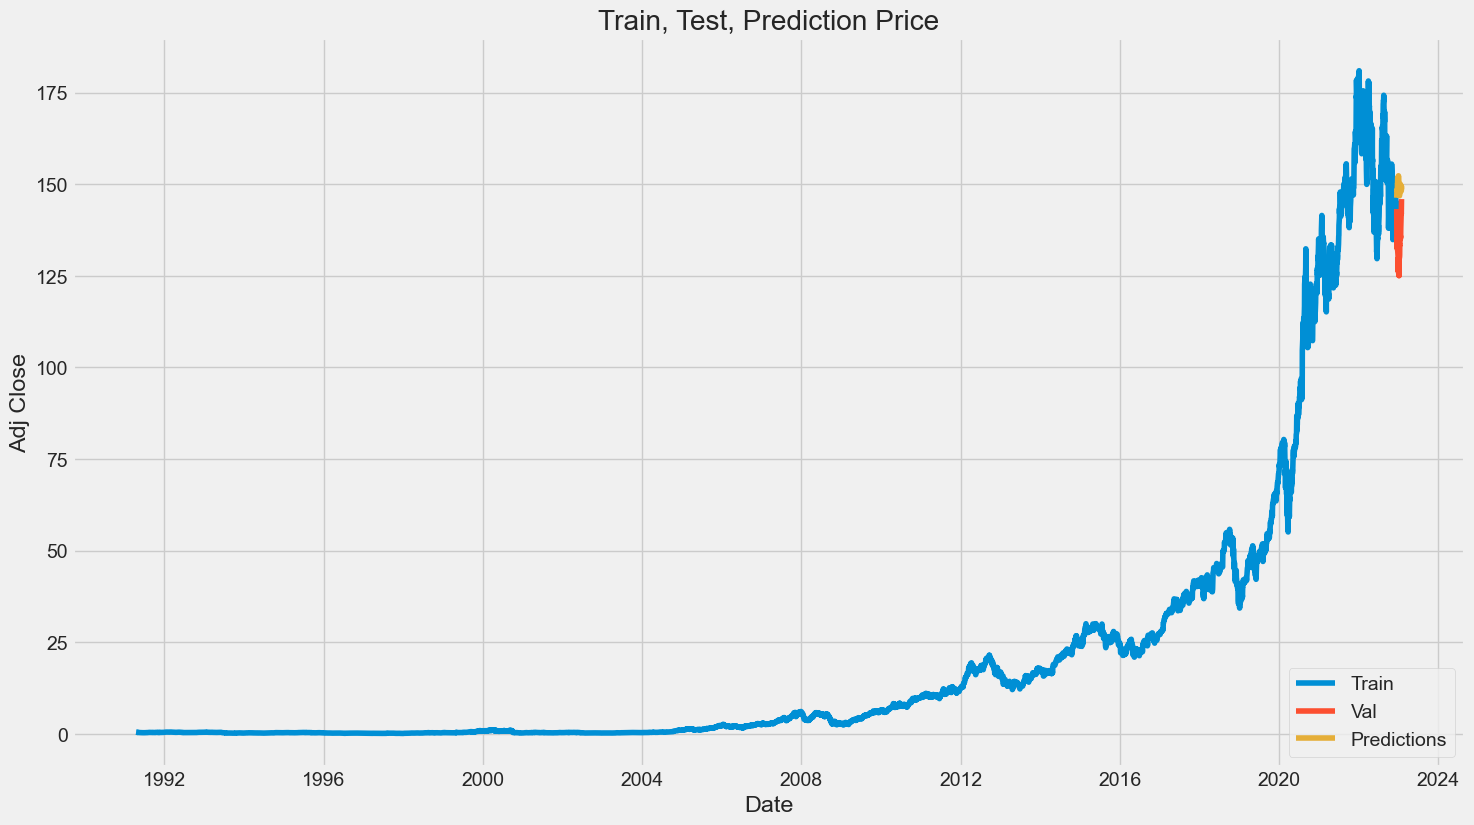

In [26]:
# vẽ đồ thị phần train, test và predict 
length = df.shape[0]
train = df[2600:length - 30]
test = df[length - 30:]
test['Predictions'] = pred_test[0]

plt.figure(figsize=(16,9))
plt.title('Train, Test, Prediction Price')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(train['Adj Close'])
plt.plot(test[['Adj Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [27]:
test

,Open,High,Low,Close,Adj Close,Volume,Predictions
Date,,,,,,,
2022-12-14,145.350006,146.660004,141.160004,143.210007,143.210007,82291200,146.288071
2022-12-15,141.110001,141.800003,136.029999,136.500000,136.500000,98931900,147.128647
2022-12-16,136.690002,137.649994,133.729996,134.509995,134.509995,160156900,148.420349
2022-12-19,135.110001,135.199997,131.320007,132.369995,132.369995,79592600,148.285934
2022-12-20,131.389999,133.250000,129.889999,132.300003,132.300003,77432800,148.896088
2022-12-21,132.979996,136.809998,132.750000,135.449997,135.449997,85928000,150.073868
2022-12-22,134.350006,134.559998,130.300003,132.229996,132.229996,77852100,150.060715
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.860001,63814900,151.795395
2022-12-27,131.380005,131.410004,128.720001,130.029999,130.029999,69007800,150.791428


In [28]:
mse = np.sqrt(np.mean((test['Adj Close'] - test['Predictions']) ** 2))
print(mse)

16.084394047657305
